In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
class UniV2:

  def __init__(self, _R0, _R1, _fee_inv):
    self.R0 = _R0
    self.R1 = _R1
    self.fee_inv = _fee_inv

  def optimal_amount_in(self, price):
    # todo: account for the fee
    return sqrt(self.R0*self.R1*price) / price - self.R0

  def price(self):
    return self.R1 / self.R0

  def get_amount_in(self, amount_out, zeroToOne=True):
    (r_in, r_out) = (self.R0, self.R1) if zeroToOne else (self.R1, self.R0)
    return r_in*amount_out / (r_out - amount_out)*self.fee_inv + 1

  def get_amount_out(self, amount_in, zeroToOne=True):
    (r_in, r_out) = (self.R0, self.R1) if zeroToOne else (self.R1, self.R0)
    amount_in_wfee = amount_in * self.fee_inv
    return r_out*amount_in_wfee / (r_in + amount_in_wfee)

  def swap(self, amount_in, zeroToOne=True):
    amount_out = self.get_amount_out(amount_in, zeroToOne)

    if zeroToOne:
      self.R0 += amount_in
      self.R1 -= amount_out
    else:
      self.R0 -= amount_out
      self.R1 += amount_in

    return amount_out


class Dex:

  def __init__(self, _univ2, _block_interval, _iter):
    self.interval = _block_interval
    self.univ2 = _univ2
    self.opp_cumm = 0
    self.opp_count = 0
    self.prices = np.zeros(_iter)

  def get_profit(self, target_price):
    optimal_amount = self.univ2.optimal_amount_in(target_price) # in zero tokens
    zero_to_one = optimal_amount > 0

    amount_in = optimal_amount
    if not zero_to_one:
      amount_in = self.univ2.get_amount_in(abs(optimal_amount), zero_to_one)

    amount_out = self.univ2.get_amount_out(amount_in, zero_to_one)

    profit = 0
    if zero_to_one:
      profit = amount_out/target_price - amount_in
    else:
      profit = amount_out - amount_in/target_price

    return (amount_in, zero_to_one), profit

  def try_arb(self, iter, p_external):
    c, profit = self.get_profit(p_external)
    if self.is_within_interval(iter) and profit > 0:
      self.univ2.swap(c[0], c[1])
      self.opp_count += 1
      self.opp_cumm += profit
    self.prices[iter] = self.univ2.price()

  def is_within_interval(self, iter):
    return iter % self.interval == 0


class Cex:

  def __init__(self, _init_price, _mean_change, _std_dev_change, _iter):
    self.mean_change = _mean_change
    self.std_dev_change = _std_dev_change
    self.price = _init_price
    self.prices = np.zeros(_iter)

  def advance_step(self, iter):
    step = 1 + np.random.normal(self.mean_change, self.std_dev_change)
    self.price *= step
    self.prices[iter] = self.price

In [20]:
p_init = 1800
fee_uni_inv = 0.9995 # 5bps pool
mean_change = 0  # Mean price change in one second
std_dev_change = 0.0002  # STD of price change in one second
iter = 100_000

interval_factor = 4
block_interval_fast = 100
block_interval_slow = block_interval_fast * interval_factor
R0 = 100_000
R1 = R0 * p_init


univ2_fast = UniV2(R0, R1, fee_uni_inv)
univ2_slow = UniV2(R0, R1, fee_uni_inv)
dex_fast = Dex(univ2_fast, block_interval_fast, iter)
dex_slow = Dex(univ2_slow, block_interval_slow, iter)
cex = Cex(p_init, mean_change, std_dev_change, iter)

for i in range(iter):
  cex.advance_step(i)
  dex_fast.try_arb(i, cex.price)
  dex_slow.try_arb(i, cex.price)

In [21]:
print(f"🐇 FAST: freq = {dex_fast.opp_count}; profits = {dex_fast.opp_cumm}")
print(f"🐢 SLOW: freq = {dex_slow.opp_count}; profits = {dex_slow.opp_cumm}")
print("fast_dex_profits / slow_dex_profits = ", dex_fast.opp_cumm / dex_slow.opp_cumm)

🐇 FAST: freq = 649; profits = 67.43287670933478
🐢 SLOW: freq = 202; profits = 84.45923335090916
fast_dex_profits / slow_dex_profits =  0.7984073976751164


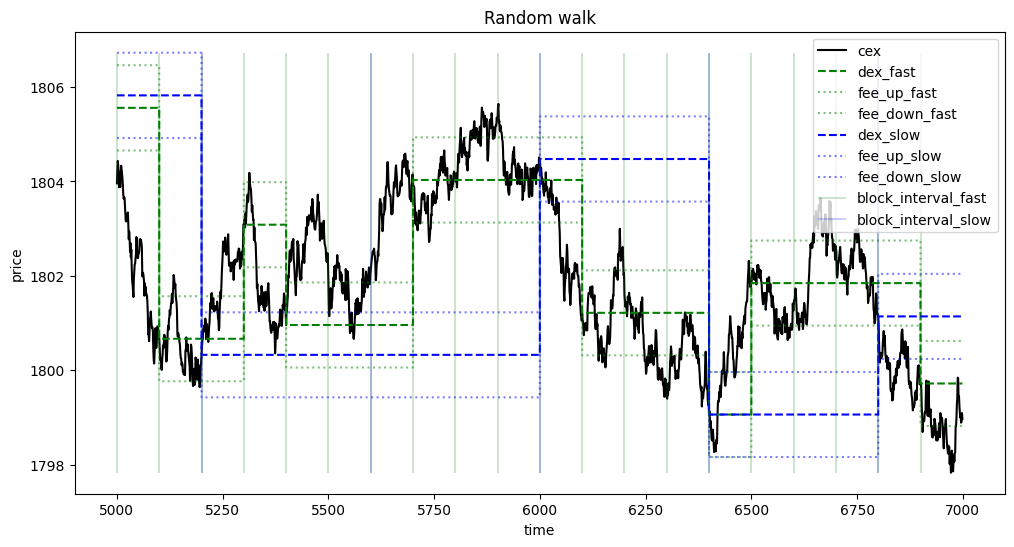

In [5]:
# Adjust the value to zoom in/out
p0 = 5000
p1 = 7000

x = np.arange(p0, p1)
y = cex.prices[p0:p1]
z = dex_fast.prices[p0:p1]
z_down = dex_fast.prices[p0:p1] * dex_fast.univ2.fee_inv
z_up = dex_fast.prices[p0:p1] / dex_fast.univ2.fee_inv
w = dex_slow.prices[p0:p1]
w_down = dex_slow.prices[p0:p1] * dex_slow.univ2.fee_inv
w_up = dex_slow.prices[p0:p1] / dex_slow.univ2.fee_inv

sets = [ y, z, z_down, z_up, w, w_down, w_up ]
ymin = min([ s.min() for s in sets ])
ymax = max([ s.max() for s in sets ])


plt.figure(figsize=(12, 6))

plt.plot(x, y, label="cex", color="black")
plt.step(x, z, "--g", label="dex_fast", where="post")
plt.step(x, z_up, ":", label="fee_up_fast", alpha=0.5, color="green", where="post")
plt.step(x, z_down, label="fee_down_fast", color="green", alpha=0.5, linestyle=':', where="post")
plt.step(x, w, "--b", label="dex_slow", where="post")
plt.step(x, w_up, label="fee_up_slow", color="blue", alpha=0.5, linestyle=':', where="post")
plt.step(x, w_down, label="fee_down_slow", color="blue", alpha=0.5, linestyle=':', where="post")


plt.vlines(x=x[x%block_interval_fast == 0], ymin=ymin, ymax=ymax, colors='green', alpha=0.2, linestyle='-', label='block_interval_fast')
plt.vlines(x=x[x%block_interval_slow == 0], ymin=ymin, ymax=ymax, colors='blue', alpha=0.2, linestyle='-', label='block_interval_slow')

plt.title('Random walk')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()